# F44: Zeeman Effect

Experiment carried out by Mathieu Kaltschmidt and Quirinus Schwarzenböck at the Max-Planck-Institute for Nuclear Physics (MPIK) in Heidelberg on the 4th of June 2019. <br>

__Supervisor:__ Florian Trost <br>

In [166]:
#Useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.special import gamma

from scipy.signal import argrelmin, argrelmax

from scipy.interpolate import interp1d

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']= 4

## Part I: Spectroscopy of the Zeeman Effect
### Magnetic field strength as function of the current

In [167]:
#Define the linear fit function
def Linear(x, m, const):
    return m*x + const

In [168]:
#DATA
I = [8.0, 9.0, 10.0, 11.0, 12.0, 13.0] #A
dI = 0.2 #A

#Increasing current with systematic errors 
B_up = np.array([[4.19, 4.17, 4.19], [4.64, 4.64, 4.65], [5.08, 5.09, 5.05], [5.51, 5.42, 5.43], [5.77, 5.75, 5.81], [5.98, 6.00, 6.04]]) * 1e-1
dB_up_syst = 0.02 * B_up

#Means  
B_up_mean = np.mean(B_up, axis = 1)
dB_up_mean_syst = 0.02 * B_up_mean
        
#Decreasing current with systematic errors 
B_down = np.array([[4.17, 4.17, 4.20], [4.62, 4.65, 4.68], [5.04, 5.03, 5.06], [5.48, 5.45, 5.52], [5.79, 5.82, 5.86], [6.03, 6.06, 6.02]]) * 1e-1
dB_down_syst = 0.02* B_down
          
#Means  
B_down_mean = np.mean(B_down, axis = 1)
dB_down_mean_syst = 0.02 * B_down_mean

In [169]:
#Perform fit
Irange = np.linspace(7.5, 13.5, 2)

#Increasing current
popt_up, pcov_up = curve_fit(Linear, I[:-1], B_up_mean[:-1], sigma= dB_up_mean_syst[:-1])
print("Results for the measurement with increasing current:")
print("m = (" + str(round(popt_up[0],3)) + " +/- " + str(round(np.sqrt(np.diag(pcov_up)[0]),3)) + ") mT/A")
print("const = (" + str(round(popt_up[1],3)) + " +/- " + str(round(np.sqrt(np.diag(pcov_up)[1]),3)) + ") mT")


#Decreasing current
popt_down, pcov_down = curve_fit(Linear, I[:-1], B_down_mean[:-1], sigma= dB_down_mean_syst[:-1])
print("Results for the measurement with decreasing current:")
print("m = (" + str(round(popt_down[0],3)) + " +/- " + str(round(np.sqrt(np.diag(pcov_down)[0]),3)) + ") mT/A")
print("const = (" + str(round(popt_down[1],3)) + " +/- " + str(round(np.sqrt(np.diag(pcov_down)[1]),3)) + ") mT")



Results for the measurement with increasing current:
m = (0.04 +/- 0.002) mT/A
const = (0.098 +/- 0.015) mT
Results for the measurement with decreasing current:
m = (0.042 +/- 0.001) mT/A
const = (0.088 +/- 0.012) mT


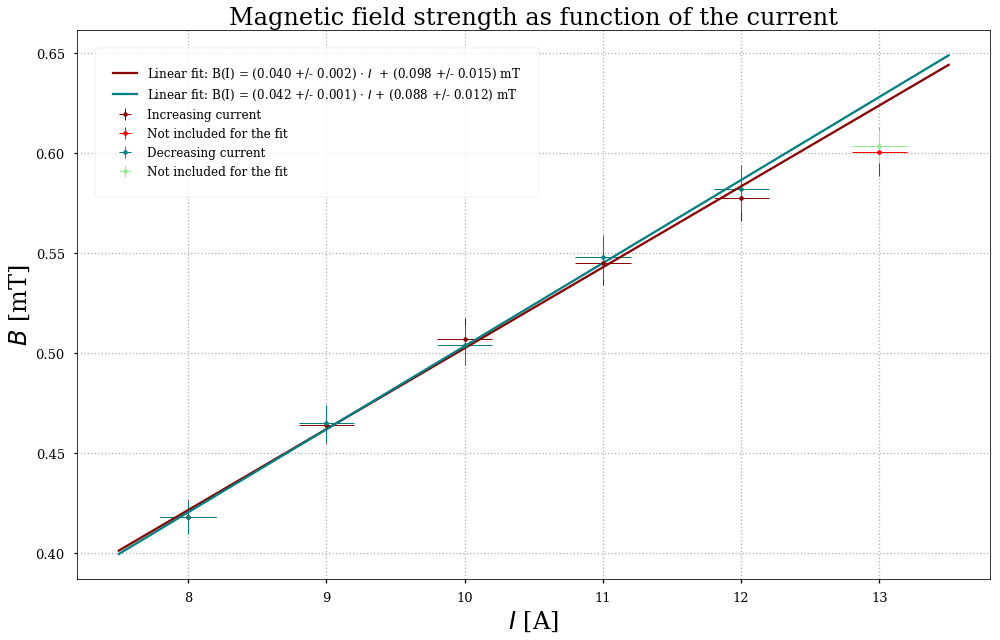

In [230]:
#Plot the result

plt.errorbar(I[:-1], B_up_mean[:-1], xerr = dI*np.ones(len(B_up_mean)-1), yerr = dB_up_mean_syst[:-1], linewidth=1, linestyle='', marker='.', color='darkred', label='Increasing current' )
plt.errorbar(I[-1], B_up_mean[-1], xerr = dI*np.ones(1), yerr = dB_up_mean_syst[-1], linewidth=1, linestyle='', marker='.', color='red', label='Not included for the fit' )
plt.plot(Irange, Linear(Irange, *popt_up), color='darkred', label=r'Linear fit: B(I) = (0.040 +/- 0.002) $\cdot \ I$  + (0.098 +/- 0.015) mT')

plt.errorbar(I[:-1], B_down_mean[:-1], xerr = dI*np.ones(len(B_down_mean)-1), yerr = dB_down_mean_syst[:-1], linewidth=1, linestyle='', marker='.', color='teal', label='Decreasing current' )
plt.errorbar(I[-1], B_down_mean[-1], xerr = dI*np.ones(1), yerr = dB_down_mean_syst[:1], linewidth=1, linestyle='', marker='.', color='lightgreen', label='Not included for the fit' )
plt.plot(Irange, Linear(Irange, *popt_down), color='teal', label=r'Linear fit: B(I) = (0.042 +/- 0.001) $\cdot \ I$ + (0.088 +/- 0.012) mT')


plt.title("Magnetic field strength as function of the current", size = 24)
plt.xlabel(r'$I$ [A]', size=24)
plt.ylabel(r'$B$ [mT]', size=24)

plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
plt.grid(ls='dotted')



#Saving figure
plt.tight_layout()
plt.savefig('Plots/MagneticField.pdf', format='PDF')

### Position of the $\sigma$- and $\pi$-lines

In [171]:
#Define the fit functions (Triple Gaussian, Gaussian and Quadratic Function)
def TripleGauss(x, N1, N2, N3, μ1, μ2, μ3, σ1, σ2, σ3):
    return N1*np.exp(-((x-μ1)**2/(σ1**2))) + N2*np.exp(-((x-μ2)**2/(σ2**2))) + N3*np.exp(-((x-μ3)**2/(σ3**2)))

In [172]:
def starting_values(intensity, pixel, order = 7):
    values = []
    maxima = argrelmax(intensity, order = order)[0]
    if len(maxima) > 3:
        maxima = maxima[:3]
    print(len(maxima))
    int_max = intensity[maxima]
    mu = 20 * np.ones(3)
    values.extend(int_max)
    values.extend(pixel[maxima])
    values.extend(mu)
    return values

/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


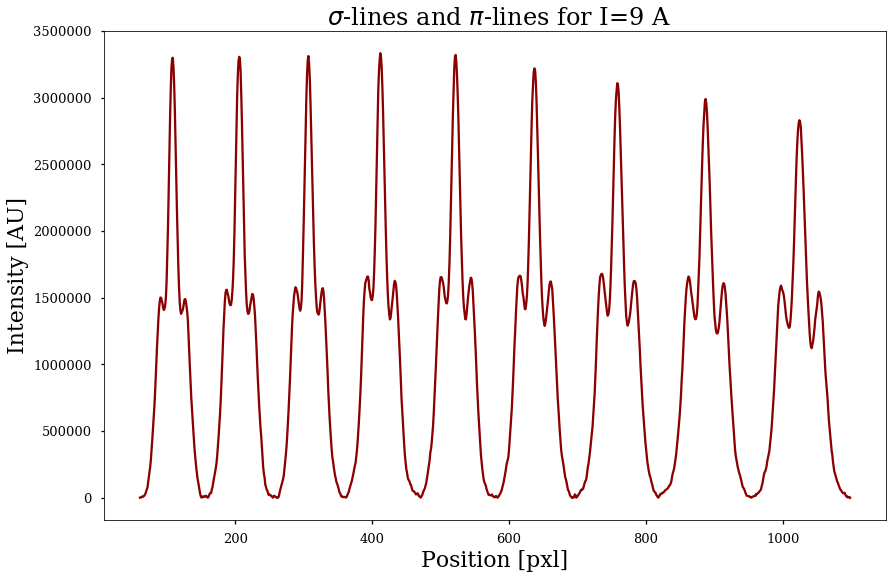

In [200]:
#Load DATA
pixels, intensity  = np.loadtxt(r'DATA/Part_I/Trans_9A.txt',unpack= True, skiprows=1)

#Determine Minima
minimum = argrelmin(intensity,order=30)[0]
pixels_min = pixels[minimum]
intensity_min = intensity[minimum]

#Interpolation with cubic function
f = interp1d(pixels_min, intensity_min , kind='quadratic')
pixelrange = np.arange(pixels_min[0], pixels_min[9])
filtered_intensity = intensity[minimum[0]:minimum[9]] - f(pixelrange)
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")
#plt.plot(pixelrange, f(pixelrange))

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=9 A", size = 24)
plt.show()

3
3
3
3
3
3
3
3
3


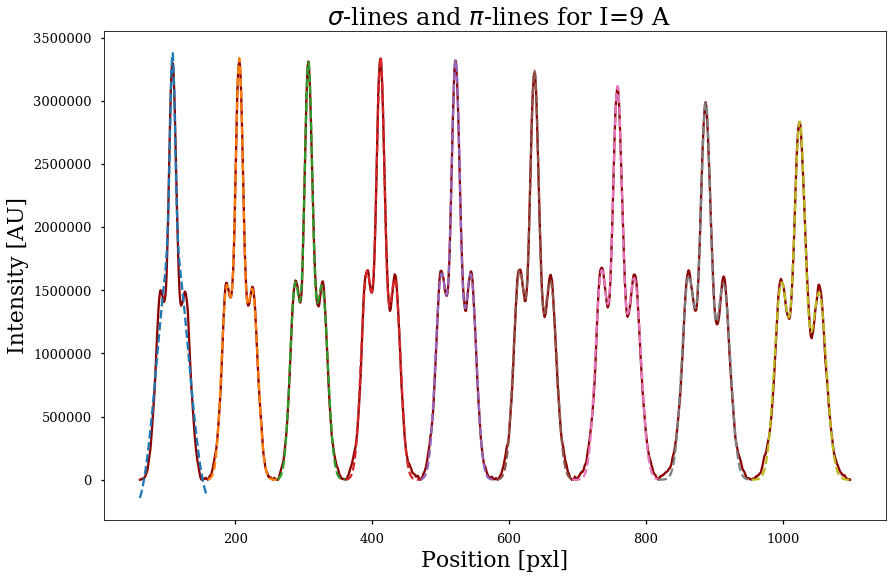

<Figure size 1008x648 with 0 Axes>

In [201]:
fit_values9 = []
minirange9 = []
minima = [0]
minima.extend(argrelmin(filtered_intensity, order = 25)[0])
minima.append(len(filtered_intensity) - 1)
for i, mini in enumerate(minima):
    if i < len(minima) - 1:
        trirange = pixelrange[minima[i]:minima[i + 1]]
        triple_int = filtered_intensity[minima[i]:minima[i + 1]]
        p0 = starting_values(triple_int, trirange, order = 7)
        popt, pcov = curve_fit(TripleGauss, trirange, triple_int, p0 = p0, maxfev = 6000)
        fit_values9.append(popt)
        minirange9.append(trirange)
        
#Plotting the fit results
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")

for i in range(len(fit_values9)):
    plt.plot(minirange9[i], TripleGauss(minirange[i] ,*fit_values9[i]), ls = "dashed")

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=9 A", size = 24)

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/9A_Trans.pdf', format='PDF')

/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


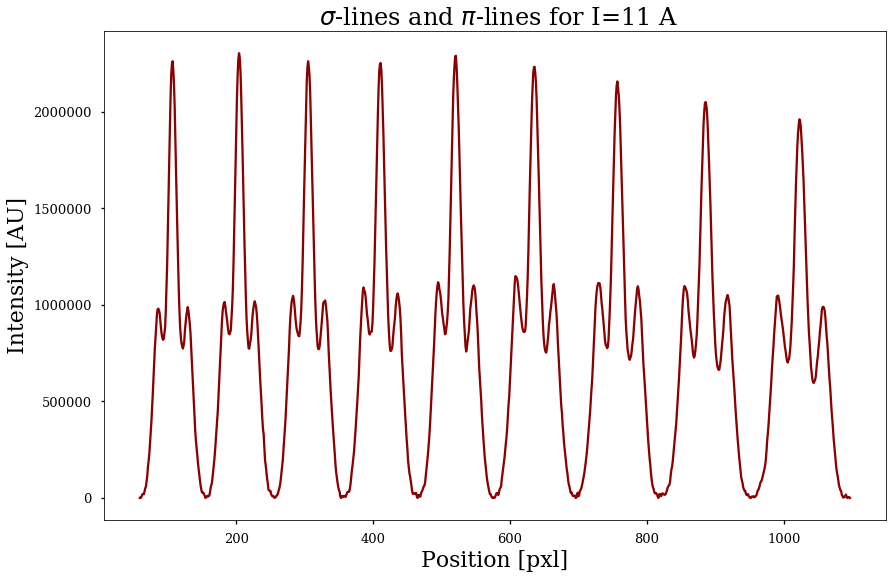

In [175]:
pixels, intensity  = np.loadtxt(r'DATA/Part_I/Trans_11A.txt',unpack= True, skiprows=1)
#Determine Minima
minimum = argrelmin(intensity,order=30)[0]
pixels_min = pixels[minimum]
intensity_min = intensity[minimum]

#Interpolation with cubic function
f = interp1d(pixels_min, intensity_min , kind='quadratic')
pixelrange = np.arange(pixels_min[0], pixels_min[9])
filtered_intensity = intensity[minimum[0]:minimum[9]] - f(pixelrange)
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")
#plt.plot(pixelrange, f(pixelrange))

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=11 A", size = 24)
plt.show()

3
3
3
3
3
3
3
3
3


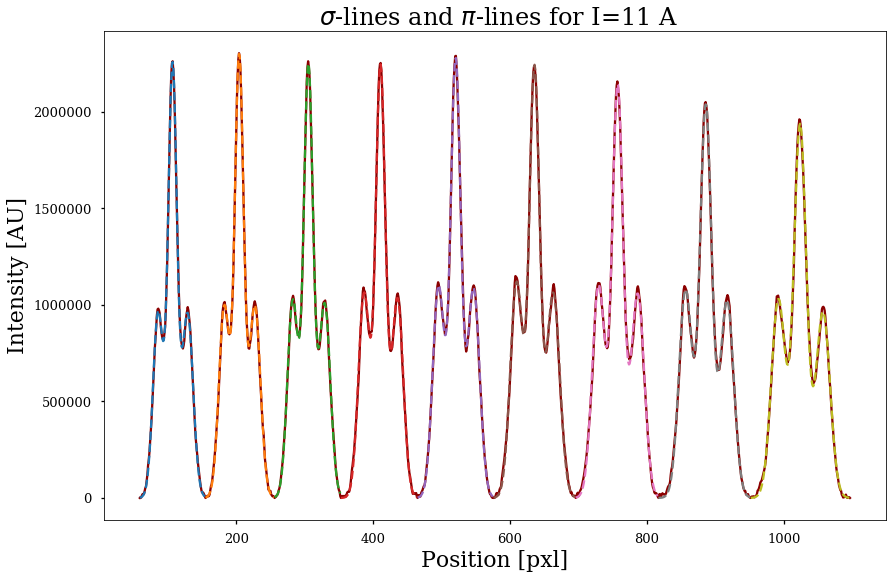

<Figure size 1008x648 with 0 Axes>

In [198]:
fit_values11 = []
minirange11 = []
minima = [0]
minima.extend(argrelmin(filtered_intensity, order = 25)[0])
minima.append(len(filtered_intensity) - 1)
for i, mini in enumerate(minima):
    if i < len(minima) - 1:
        trirange = pixelrange[minima[i]:minima[i + 1]]
        triple_int = filtered_intensity[minima[i]:minima[i + 1]]
        p0 = starting_values(triple_int, trirange, order = 7)
        popt, pcov = curve_fit(TripleGauss, trirange, triple_int, p0 = p0, maxfev = 6000)
        fit_values11.append(popt)
        minirange11.append(trirange)
        
#Plotting the fit results
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")

for i in range(len(fit_values11)):
    plt.plot(minirange11[i], TripleGauss(minirange11[i] ,*fit_values11[i]), ls = "dashed")

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=11 A", size = 24)

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/11A_Trans.pdf', format='PDF')

/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/anaconda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


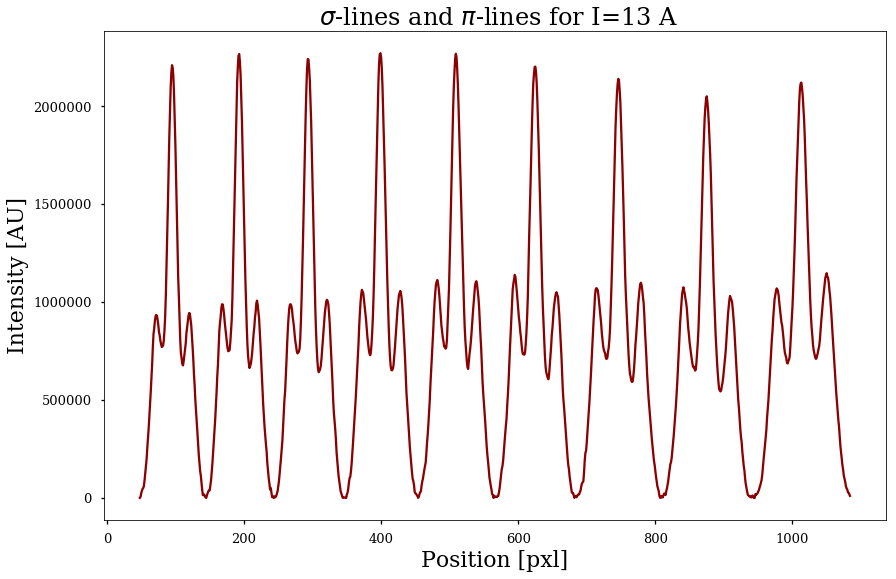

In [88]:
pixels, intensity  = np.loadtxt(r'DATA/Part_I/Trans_13A.txt',unpack= True, skiprows=1)
#Determine Minima
minimum = argrelmin(intensity,order=30)[0]
pixels_min = pixels[minimum]
intensity_min = intensity[minimum]

#Interpolation with cubic function
f = interp1d(pixels_min, intensity_min , kind='quadratic')
pixelrange = np.arange(pixels_min[0], pixels_min[9])
filtered_intensity = intensity[minimum[0]:minimum[9]] - f(pixelrange)
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")
#plt.plot(pixelrange, f(pixelrange))

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=13 A", size = 24)
plt.show()

3
3
3
3
3
3
3
3
3


/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


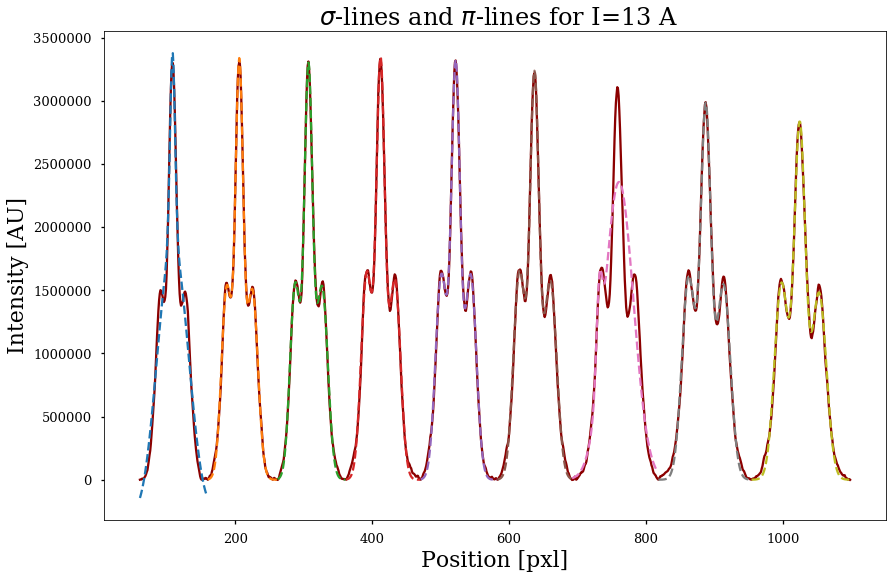

<Figure size 1008x648 with 0 Axes>

In [235]:
fit_values13 = []
minirange13 = []
minima = [0]
minima.extend(argrelmin(filtered_intensity, order = 30)[0])
minima.append(len(filtered_intensity) - 1)
for i, mini in enumerate(minima):
    if i < len(minima) - 1:
        trirange = pixelrange[minima[i]:minima[i + 1]]
        triple_int = filtered_intensity[minima[i]:minima[i + 1]]
        p0 = starting_values(triple_int, trirange, order = 4)
        popt, pcov = curve_fit(TripleGauss, trirange, triple_int, p0 = p0, maxfev = 6000)
        fit_values13.append(popt)
        minirange13.append(trirange)
        
#Plotting the fit results
plt.plot(pixels[minimum[0]:minimum[9]], filtered_intensity, color = "darkred")

for i in range(len(fit_values13)):
    plt.plot(minirange13[i], TripleGauss(minirange13[i] ,*fit_values13[i]), ls="dashed")

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r" $\sigma$-lines and $\pi$-lines for I=13 A", size = 24)

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/13A_Trans.pdf', format='PDF')

### Order of interference against positions 

In [177]:
orders = np.arange(0,9)

mid9 = []
sig9 = []
for i in fit_values9:
    mid9.append(i[4])
    sig9.append(i[7])
mid11 = []
sig11 = []
for i in fit_values11:
    mid11.append(i[4])
    sig11.append(i[7])
mid13 = []
sig13 = []
for i in fit_values13:
    mid13.append(i[4])
    sig13.append(i[7])

In [178]:
def Quadratic(x, C1, C2, C3):
    return C1*x**2 + C2*x + C3

rangei = np.linspace(0, 1200, 1000)
popt9, pcov9 = curve_fit(Quadratic, mid9, orders, sigma=sig9)

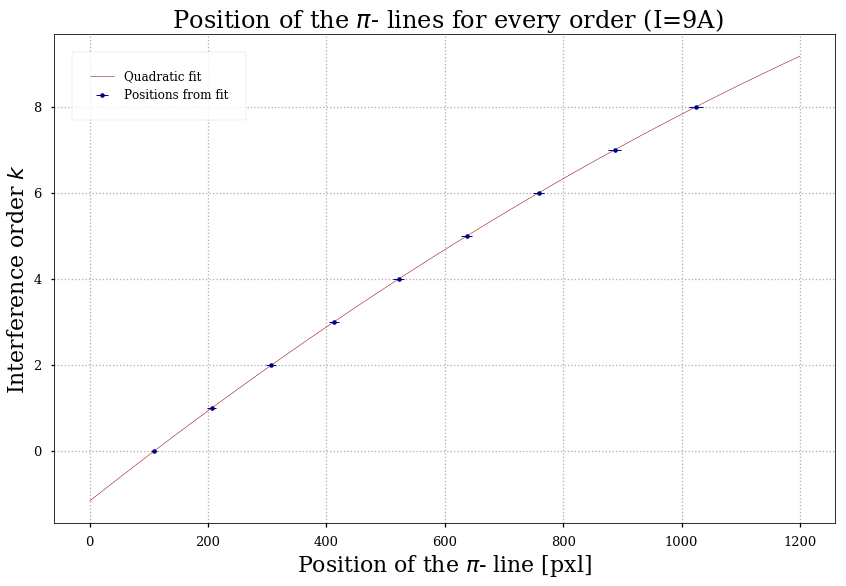

<Figure size 1008x648 with 0 Axes>

In [203]:
plt.errorbar(mid9, orders, xerr = sig9, linewidth=1, linestyle='', marker='.', color='darkblue', label='Positions from fit' )
plt.plot(rangei, Quadratic(rangei, *popt9), lw= '0.5', color='darkred', label=r'Quadratic fit')

plt.ylabel("Interference order $k$", size = 22)
plt.xlabel("Position of the $\pi$- line [pxl]", size = 22)
plt.title(r" Position of the $\pi$- lines for every order (I=9A)", size = 24)


plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
plt.grid(ls='dotted')

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/9A_Orders.pdf', format='PDF')

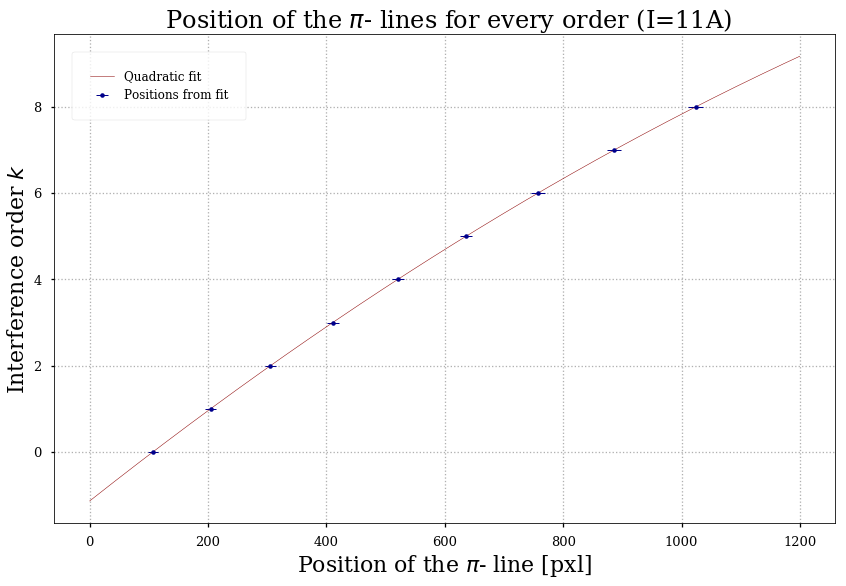

<Figure size 1008x648 with 0 Axes>

In [204]:
range11 = np.linspace(-0.5, 9, 100)
popt11, pcov11 = curve_fit(Quadratic,  mid11, orders, sigma=sig11)

plt.errorbar(mid11, orders, xerr = sig11, linewidth=1, linestyle='', marker='.', color='darkblue', label='Positions from fit' )
plt.plot(rangei, Quadratic(rangei, *popt11), lw= '0.5', color='darkred', label=r'Quadratic fit')

plt.ylabel("Interference order $k$", size = 22)
plt.xlabel("Position of the $\pi$- line [pxl]", size = 22)
plt.title(r" Position of the $\pi$- lines for every order (I=11A)", size = 24)


plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
plt.grid(ls='dotted')

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/11A_Orders.pdf', format='PDF')

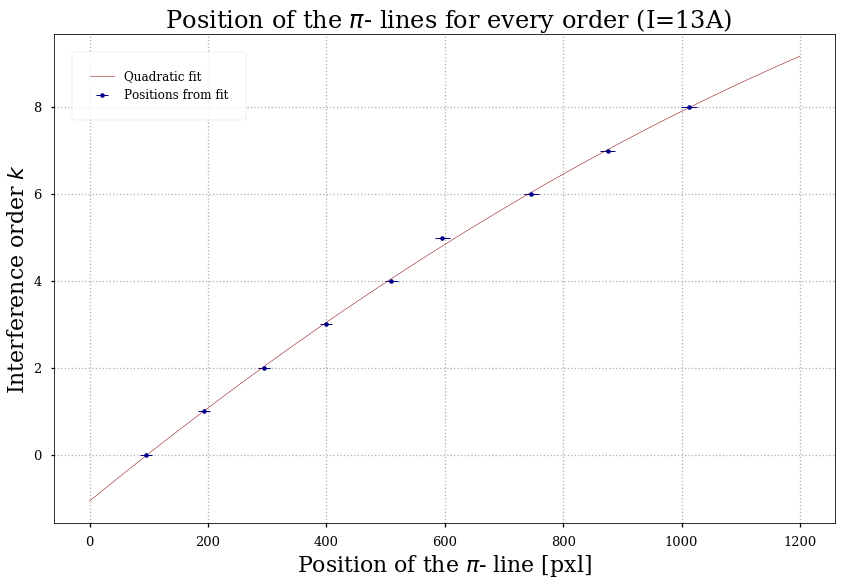

<Figure size 1008x648 with 0 Axes>

In [205]:
range13 = np.linspace(-0.5, 9, 100)
popt13, pcov13 = curve_fit(Quadratic,  mid13, orders, sigma=sig13)

plt.errorbar(mid13, orders, xerr = sig13, linewidth=1, linestyle='', marker='.', color='darkblue', label='Positions from fit' )
plt.plot(rangei, Quadratic(rangei, *popt13), lw= '0.5', color='darkred', label=r'Quadratic fit')

plt.ylabel("Interference order $k$", size = 22)
plt.xlabel("Position of the $\pi$- line [pxl]", size = 22)
plt.title(r" Position of the $\pi$- lines for every order (I=13A)", size = 24)


plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
plt.grid(ls='dotted')

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/13A_Orders.pdf', format='PDF')

### Relations between interference orders

In [182]:
#Lummer-Gehrke plate
n=1.4567
dn=n*0.005
d=4.04e-3 #m
dd=d*0.005

#From Part II
lamda=643.87e-9 
dlamda=0.15e-9

h=6.62606876e-34
c=299792458

In [183]:
def calca(a,b,c,d):
    a2p=a/(2*b)+np.sqrt((a/(2*b))**2-(c-d/b))
    return a2p

def a_ratio(fitparameter,position):
    D_a=[]
    for i in range(1,10):
        Deltaa=calca(*fitparameter,i+1)-calca(*fitparameter,i)
        D_a=D_a + [Deltaa]

    posnull=[0]+position
    d_a=[]
    for i in range(0,8):
        deltaa2=posnull[i+2]-posnull[i+1]
        deltaa1=posnull[i+1]-posnull[i+0]
        mean=np.array([deltaa1,deltaa2])
        d_a=d_a+[np.mean(mean)]

    ratio=np.array([])
    for i in range(0,8):
        ratio=np.append(ratio,d_a[i]/D_a[i])
    ratio_mean=-np.mean(ratio)
    ratio_std=np.std(ratio)
    return ratio_mean, ratio_std


def mu_b(ratio,ratio_std,B,dB):
    d_lambda=ratio*lamda**2/(2*d*np.sqrt( n**2-1)) 
    dd_lambda=np.sqrt((ratio_std*lamda**2/(2*d*np.sqrt(n**2-1)))**2+(ratio*lamda*dlamda/(d*np.sqrt(n**2-1)))**2+(ratio*lamda**2*dd/(2*d**2*np.sqrt(n**2-1)))**2+(ratio*lamda**2*dn*n/(2*d*(n**2-1)**(5/2)))**2)

    mub=(h*c/B)*d_lambda/(lamda*(lamda+d_lambda))
    
    g=(lamda*(lamda+d_lambda))
    d_mub=mub*np.sqrt((dB/B)**2+((dd_lambda/d_lambda)*(g-lamda*d_lambda)/g)**2+(dlamda*(2*lamda+d_lambda)/g)**2)
    return mub, d_mub

ratio_mean9=a_ratio(popt9, mid9)[0] # für I=9A transversal
ratio_mean11=a_ratio(popt11,mid11)[0] # für I=11A transversal
ratio_mean13=a_ratio(popt13,mid13)[0] # für I=13A transversal

ratio_std9=a_ratio(popt9,mid9)[1] # für I=9A transversal
ratio_std11=a_ratio(popt11,mid11)[1] # für I=11A transversal
ratio_std13=a_ratio(popt13,mid13)[1] # für I=13A transversal


mu_b9=mu_b(ratio_mean9,ratio_std9, Linear(9, *popt_up), Linear(9,popt_up[0]+np.sqrt(pcov_up[0][0]),popt_up[1]+np.sqrt(pcov_up[1][1]))-Linear(9, *popt_up))
mu_b11=mu_b(ratio_mean11,ratio_std11,Linear(11, *popt_up),Linear(11,popt_up[0]+np.sqrt(pcov_up[0][0]),popt_up[1]+np.sqrt(pcov_up[1][1]))-Linear(11, *popt_up))
mu_b13=mu_b(ratio_mean13,ratio_std13,Linear(13, *popt_up),Linear(13,popt_up[0]+np.sqrt(pcov_up[0][0]),popt_up[1]+np.sqrt(pcov_up[1][1]))-Linear(13, *popt_up))

print("da/Da: ",ratio_mean9,"+-",ratio_std9)
print(r"mu_b= ",mu_b9)
print()
print("da/Da:",ratio_mean11," +- ",ratio_std11)
print(r"mu_b= ", mu_b11)
print()
print("da/Da:",ratio_mean13,"+-",ratio_std13)
print(r"mu_b=",mu_b13)

da/Da:  -52.0271439778 +- 17.8208792306
mu_b=  (-2.6233834837868647e-21, -9.1750571977805598e-22)

da/Da: -52.0450014105  +-  17.9070387576
mu_b=  (-2.2331284858268348e-21, -7.8297602668138438e-22)

da/Da: -52.7809572157 +- 19.8001168163
mu_b= (-1.9710419937995482e-21, -7.5094930362097924e-22)


### Calculation of the Bohr magneton

In [184]:
#Literature value
muB_lit = 9.27400949e-24 #J/T

## Part II: Precision Spectroscopy
### Position of the Neon lines for Calibration

In [185]:
#Calibration function to convert pixels into wavelengths
def Gaussian(x,N,μ,σ): 
    return N/(np.sqrt(2*np.pi)*σ) * np.exp(-(x-μ)**2/2/σ**2) + -1.67105693e+07

def Calibrate(P,m,const):
    return m*P + const

In [186]:
pixels, intensity  = np.loadtxt(r'DATA/Part_II/Neon.txt',unpack= True, skiprows=1)

#Fitting the Neon spectrun
range1 = np.linspace(50, 180, 100)
popt1, pcov1 = curve_fit(Gaussian, pixels[50:180], intensity[50:180], p0 = [1.45e7, 110, 25])

range2 = np.linspace(940, 1025, 100)
popt2, pcov2 = curve_fit(Gaussian, pixels[940:1025], intensity[940:1025], p0 = [0.6e7, 970, 25])

range3 = np.linspace(1100, 1175, 100)
popt3, pcov3 = curve_fit(Gaussian, pixels[1100:1175], intensity[1100:1175], p0 = [0.9e7, 1120, 25])

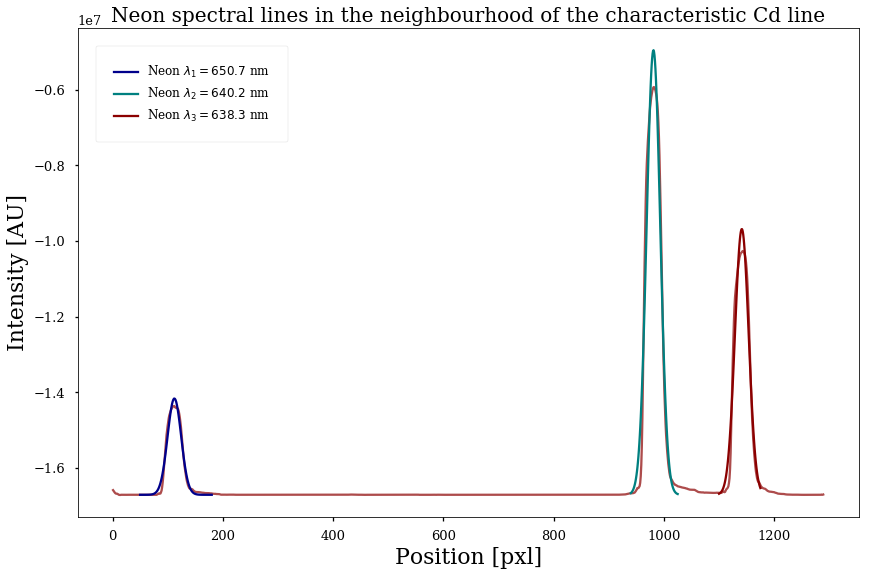

<Figure size 1008x648 with 0 Axes>

In [232]:
pixels, intensity  = np.loadtxt(r'DATA/Part_II/Neon.txt',unpack= True, skiprows=1)

plt.plot(pixels, intensity, color = "darkred", alpha=0.7)

plt.plot(range1, Gaussian(range1,*popt1),color = 'darkblue', label= r'Neon $\lambda_1 = 650.7$ nm')
plt.plot(range2, Gaussian(range2,*popt2),color = 'teal', label= r'Neon $\lambda_2 = 640.2$ nm')
plt.plot(range3, Gaussian(range3,*popt3),color = 'darkred', label= r'Neon $\lambda_3 = 638.3$ nm')

plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r"Neon spectral lines in the neighbourhood of the characteristic Cd line", size = 20)
plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc=2)

plt.show()

#Saving figure
plt.tight_layout()
plt.savefig('Plots/Neon.pdf', format='PDF')

### Calibration function

In [188]:
pos = [popt1[1], popt2[1], popt3[1]]
pos_std = [popt1[2], popt2[2], popt3[2]]

In [211]:
popt, pcov = curve_fit(Linear, pos, [650.7, 640.2, 638.3], sigma = pos_std)

In [221]:
print("Calibration: lambda = (", popt[0], "+/-", np.sqrt(pcov[0][0]), ")*Pixels + (",  popt[1], "+/-", np.sqrt(pcov[1][1]), ") nm") 

Calibration: lambda = ( -0.0120612657668 +/- 3.00713844856e-05 )*Pixels + ( 652.050556493 +/- 0.0261544637694 ) nm


### Characteristic Cadmium-line

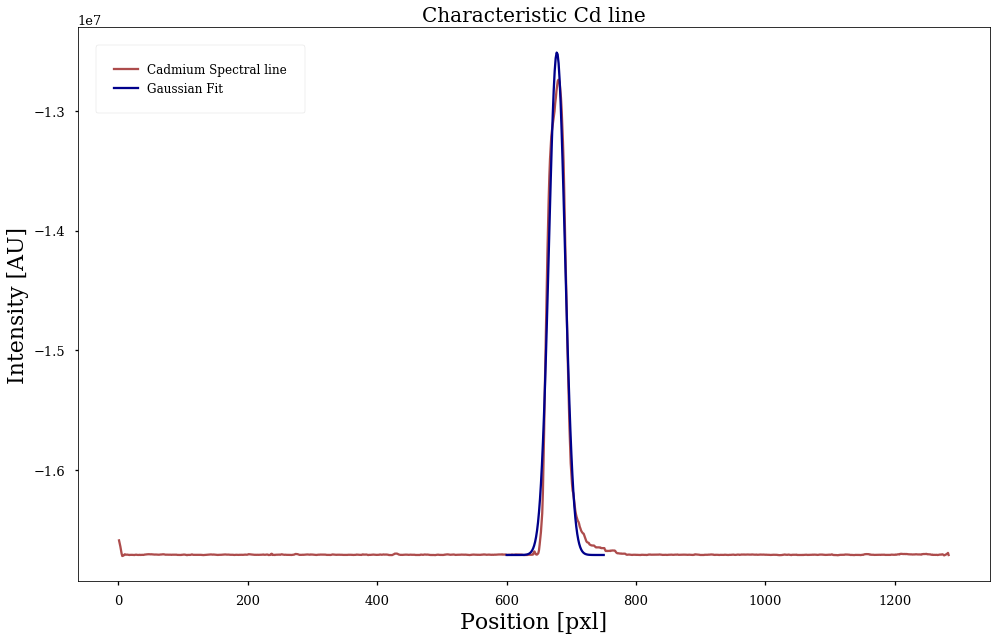

In [234]:
pixels, intensity  = np.loadtxt(r'DATA/Part_II/Cadmium.txt',unpack= True, skiprows=1)

poptCa, pcovCa = curve_fit(Gaussian, pixels[600:750], intensity[600:750], p0 = [0.45e7, 700, 25])
rangeCa = np.linspace(600, 750, 100)

plt.plot(pixels, intensity, color = "darkred", alpha=0.7, label = 'Cadmium Spectral line')
plt.plot(rangeCa, Gaussian(rangeCa, *poptCa), color = 'darkblue', label = 'Gaussian Fit')
plt.xlabel("Position [pxl]", size = 22)
plt.ylabel("Intensity [AU]", size = 22)
plt.title(r"Characteristic Cd line", size = 20)
plt.legend(frameon=True, fontsize='large', borderpad=1.5, borderaxespad=1.5,loc=2)

#Saving figure
plt.tight_layout()
plt.savefig('Plots/Cadmium.pdf', format='PDF')

In [216]:
print("Determined wavelength for the Cd line:")
print("lambda = (", Linear(poptCa[1], *popt), " +/- ", Linear(poptCa[1], *popt) - Linear(poptCa[1] + poptCa[2], *popt), ") nm")

Determined wavelength for the Cd line:
lambda = ( 643.876936733  +/-  0.150514760427 ) nm
